# Clustering Stocks for Short-term and Long-term Investment

## Context

The stock market captivates many and rewards few. Some investors rake in cash, while others lose their entire life savings in one fell swoop. One question any investor will inevitably ask is: what stocks should I pay attention to? In a sea of endless tickers, that question can seem insurmountable. Luckily we have tools that can guide us along the path to financial success (or ruin). Two of those tools are K-means and Hierarchical Clustering algorithms. 


## Objective

We want to identify groups of stocks for both long-term and short-term investments. To that end, we are going to analyze a dataset composed of a few hundred companies on the NYSE. The dataset provides several indicators for each ticker. See them in the data dictionary [below](#data_dict).

First, **we will use K-means and Hierarchical Clustering to group similar stocks together based on these indicators**. Then we will look at each cluster and identify trends within them. Based on these conclusions, we will provide potential stock picks for each investment approach. This insight will provide a launch point for further financial analysis.

This is not financial advice.

## Data Dictionary <a id='data_dict'></a>

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Table of Contents
1. [Data Overview](#data_overview)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#data_preprocessing)
4. [K-means Clustering](#k-means)
5. [Hierarchical Clustering](#hierarchical)
6. [K-means vs. Hierarchical Clustering](#vs)
7. [Actionable Insights & Recommendations](#insights_and_recs)

## Importing libraries and data

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

# for clustering and measuring performance
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# for formatting
%load_ext nb_black

# importing data
data = pd.read_csv("stock_data.csv")

<IPython.core.display.Javascript object>

## Data Overview <a id='data_overview'></a>

In [2]:
print(f"There are", data.shape[0], "rows and", data.shape[1], "columns.")

There are 340 rows and 15 columns.


<IPython.core.display.Javascript object>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

<IPython.core.display.Javascript object>

- The first four columns contain text, so they are object datatypes.
- The remaining columns are numeric.
    - `ROE`, `Cash Ratio`, `Net Cash Flow`, and `Net Income` are all integers.
    - The remaining numeric columns are floats.
- There are 340 non-null values in every column, suggesting that there are no null values in the dataset.

In [4]:
data.sample(5, random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102


<IPython.core.display.Javascript object>

- As follows from the observations above, the first four columns contain text that identify the stock and its sector.
- The remaining columns contain numerical data about various stock metrics.
- In this sample, there appear to be large differences in values. FB has a cash ratio of 958, while AIV's is only 47. DVN has a net income of -\\$14,454,000,000, while AIV's net income is \$248,710,000. There will likely be high variability and outliers in the data.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.0,8.086234e+01,9.805509e+01,4.500000e+00,3.855500e+01,5.970500e+01,9.288000e+01,1.274950e+03
Price Change,340.0,4.078194e+00,1.200634e+01,-4.712969e+01,-9.394838e-01,4.819505e+00,1.069549e+01,5.505168e+01
Volatility,340.0,1.525976e+00,5.917984e-01,7.331632e-01,1.134878e+00,1.385593e+00,1.695549e+00,4.580042e+00
ROE,340.0,3.959706e+01,9.654754e+01,1.000000e+00,9.750000e+00,1.500000e+01,2.700000e+01,9.170000e+02
Cash Ratio,340.0,7.002353e+01,9.042133e+01,0.000000e+00,1.800000e+01,4.700000e+01,9.900000e+01,9.580000e+02
Net Cash Flow,340.0,5.553762e+07,1.946365e+09,-1.120800e+10,-1.939065e+08,2.098000e+06,1.698108e+08,2.076400e+10
Net Income,340.0,1.494385e+09,3.940150e+09,-2.352800e+10,3.523012e+08,7.073360e+08,1.899000e+09,2.444200e+10
Earnings Per Share,340.0,2.776662e+00,6.587779e+00,-6.120000e+01,1.557500e+00,2.895000e+00,4.620000e+00,5.009000e+01
Estimated Shares Outstanding,340.0,5.770283e+08,8.458496e+08,2.767216e+07,1.588482e+08,3.096751e+08,5.731175e+08,6.159292e+09
P/E Ratio,340.0,3.261256e+01,4.434873e+01,2.935451e+00,1.504465e+01,2.081988e+01,3.176476e+01,5.280391e+02


<IPython.core.display.Javascript object>

#### Observations:
- ``Current Price``
    - The mean stock price is \\$80.86, but the standard deviation is \$98.06. This indicates high variability in stock price.
    - The minimum stock price is only \\$4.50, but the maximum is \$1,274.95. The 75th percentile falls at \\$92.88, so the larger values are definitely outliers.
- ``Price Change``
    - Price change is somewhat more balanced. The mean is 4.08% and the median is 4.82%. Because these values are close to each other, it is possible that the distribution is symmetrical.
    - The minimum is -47.13% and the maximum is 55.05%. These values are relatively similar in magnitude, which further bolsters the symmetrical distribution idea.
- ``Volatility``
    - Volatility values are much smaller than the previous two columns. The mean is 1.53 and the median is 1.39. The standard deviation is only 0.59. 50% of the values fall between 1.13 and 1.7, and the maximum is 4.58. The larger values are outliers.
- ``ROE``
    - ROE has a mean of 39.6 and a standard deviation of 96.55, indicating high variability. The median is 15, which is much smaller than the mean. This suggests that the distribution is heavily right-skewed. 
    - 50% of the values fall between 9.75 and 27, while the maximum is 917. The large maximum explains why the mean is higher than the median, and we are most certainly dealing with outliers in this column.
- ``Cash Ratio``
    - The mean is 70.02 and the standard deviation is 90.42. This again indicates high variability.
    - While 50% of values fall between 18 and 99, the minimum is 0 and the maximum is 958. Similar to ROE, we are likely dealing with outliers on both ends of the distribution.
- ``Net Cash Flow``
    - This column has values that vary considerably. The mean is \\$55,537,620, while the standard deviation is \$1,946,365,000. The large standard deviation suggests that the values in this column are far apart.
    - The minimum is \\$-11,208,000,000 and the maximum is \\$20,764,000,000. The 25th and 75th percentiles are -\\$193,906,500 and \$169,810,800 respectively. The median is smaller than the mean, which indicates that the data is right-skewed. However, the values seem to reflect some degree of symmetry and normality.
- ``Net Income``
    - This column exhibits characteristics similar to the previous column.
    - The mean is \\$1,494,385,000 and the median is \$707,336,000, suggesting right-skewness.
    - While the minimum and the maximum are similar in magnitude at -\\$23,528,000,000 and \$24,442,000,000 respectively, the 25th percentile falls on \\$352,301,200, which also points to right-skewness.
    - This column is likely near normal with slight skewness to the right.
- ``Earnings Per Share``
    - The median is slightly higher than the mean.
    - 50% of values fall between 1.56 and 4.62, while the minimum is -61.2 and the maximum is 50.09. While the distribution is probably normal and slightly left-skewed, there are most likely outliers on both sides of the distribution.
- ``Estimated Shares Outstanding``
    - The mean of \\$577,028,300 is higher than the median of $309,675,100, suggesting right-skewness. 
    - The even spread of values across the 25th, 50th, and 75th percentiles indicates normality.
    - There are likely outliers on either end of the distribution.
- ``P/E Ratio``
    - The mean of 32.61 is higher than the median of 20.82, again indicating right-skewness.
    - The minimum is 2.93, while the maximum is 528.04. There are probably outliers on either end of the distribution, with most of the outliers falling to the right.
- ``P/B Ratio``
    - The mean and median are close to one another.
    - The 75th percentile is at 3.92, while the maximum is 129.06. There are definitely outliers in this column.

## Exploratory Data Analysis (EDA) <a id='eda'></a>

In [6]:
# defining a function to create a histogram and boxplot in a single graph
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # for the boxplot
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # for histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # adding the mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # adding the median to the histogram

<IPython.core.display.Javascript object>

### Univariate Analysis

#### GICS Sector

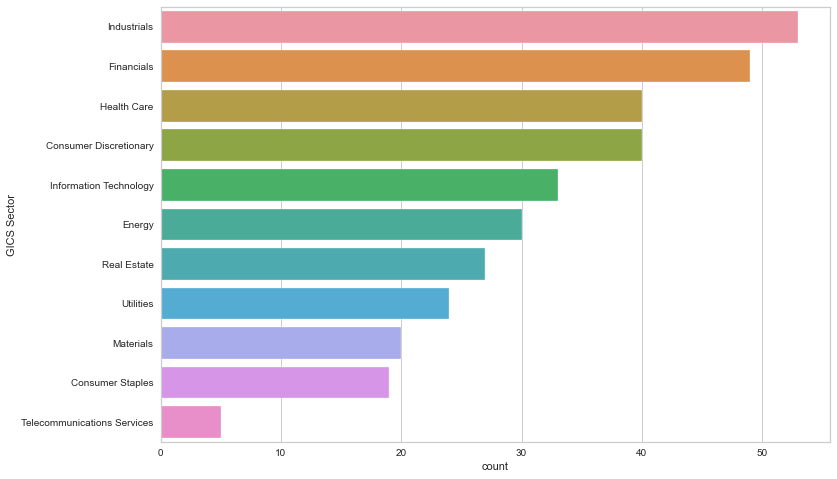

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=data, y="GICS Sector", order=data["GICS Sector"].value_counts().index
)
plt.show()

- The most common stock sector is Industrials.
- The second most common is Financials.
- Health Care and Consumer Discretionary sectors are tied for third.
- Telecommunications Services is the rarest GICS sector.

#### GICS Sub Industry

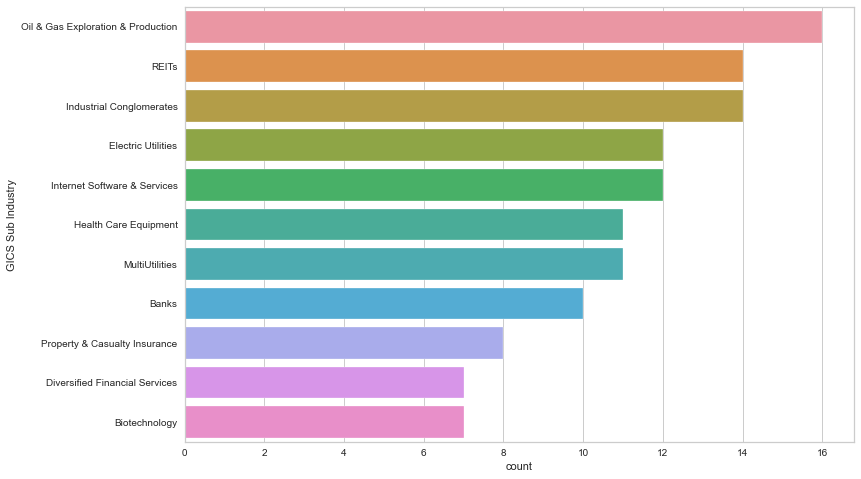

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=data,
    y=data["GICS Sub Industry"],
    order=data["GICS Sub Industry"].value_counts().iloc[:11].index,
)
plt.show()

- There are too many sub industries to depict all of them visually, so these are the top 11 most common.
- Oil & Gas Exploration & Production is the most common sub industry.
- REITs and Industrial Conglomerates are both the second most common.
- Electric Utilities and Internet Software & Services are the third most common.
- The top four sub-categories are energy/industrial or real estate related.

#### Current Price

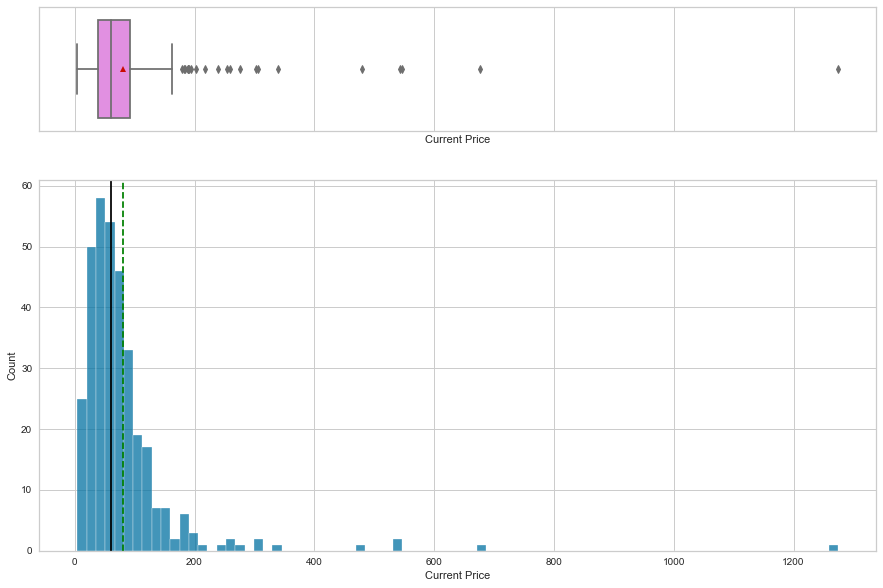

<IPython.core.display.Javascript object>

In [9]:
histogram_boxplot(data, "Current Price")

- This distribution is near normal with significant right-skewness.

#### Price Change

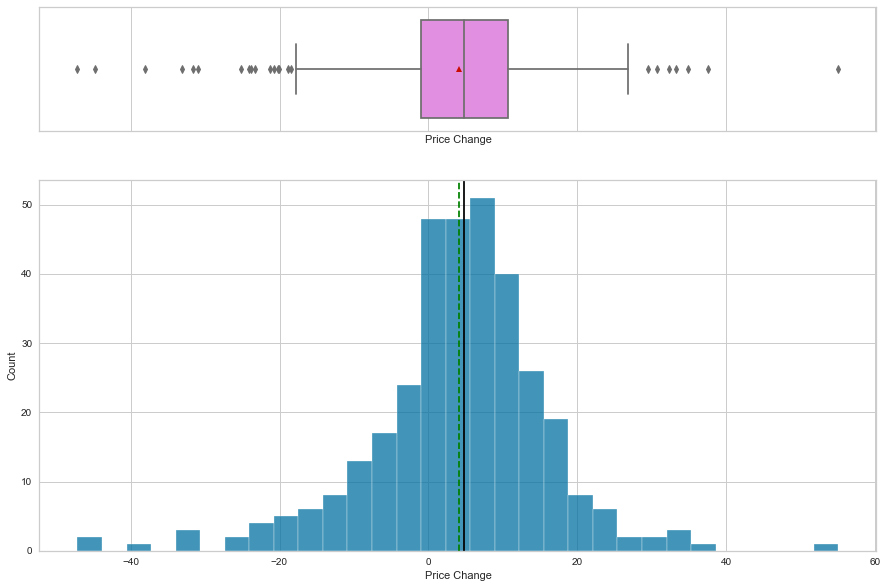

<IPython.core.display.Javascript object>

In [10]:
histogram_boxplot(data, "Price Change")

- This distribution is normal with outliers on either side.
- Half the values fall between -0.94% and 10.7%.

#### Volatility

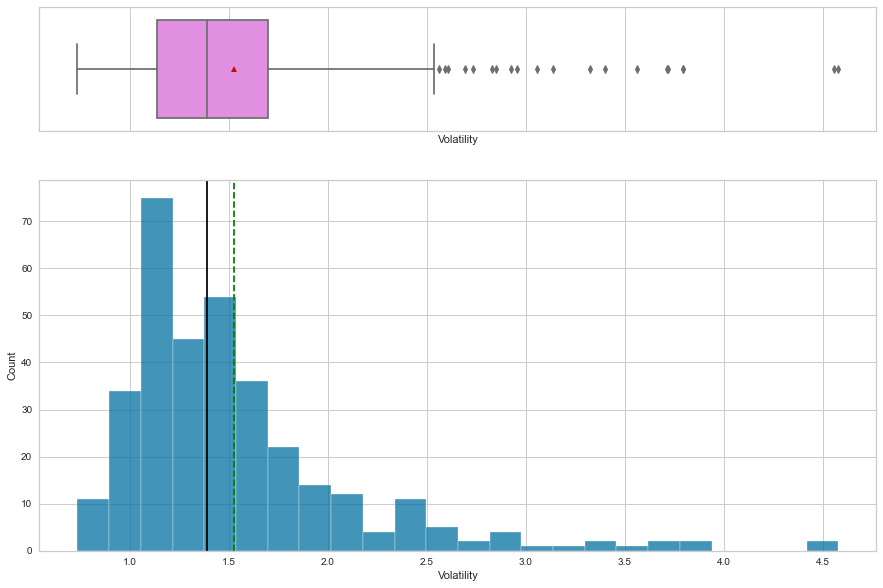

<IPython.core.display.Javascript object>

In [11]:
histogram_boxplot(data, "Volatility")

- ``Volatility`` is right-skewed with several outliers to the right.

#### ROE

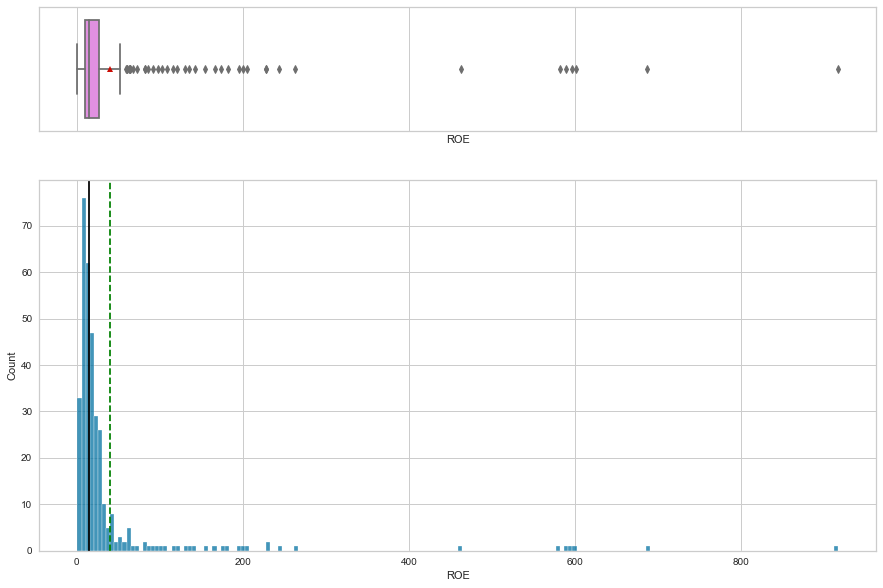

<IPython.core.display.Javascript object>

In [12]:
histogram_boxplot(data, "ROE")

- ``ROE`` is extremely right-skewed.
- There are several outliers that lie far beyond the boxplot whiskers.
    - This indicates that there are a few companies that are far more profitable than the rest.

#### Cash Ratio

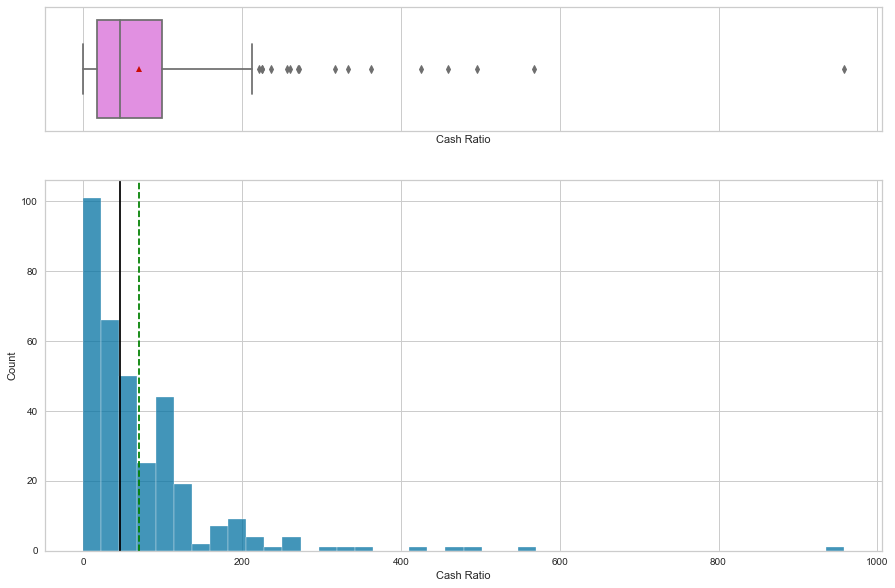

<IPython.core.display.Javascript object>

In [13]:
histogram_boxplot(data, "Cash Ratio")

- Most values are near 0. The value frequencies decrease significantly as the ``Cash Ratio`` increases.
- There are many outliers to the right of the right boxplot whisker.

#### Net Cash Flow

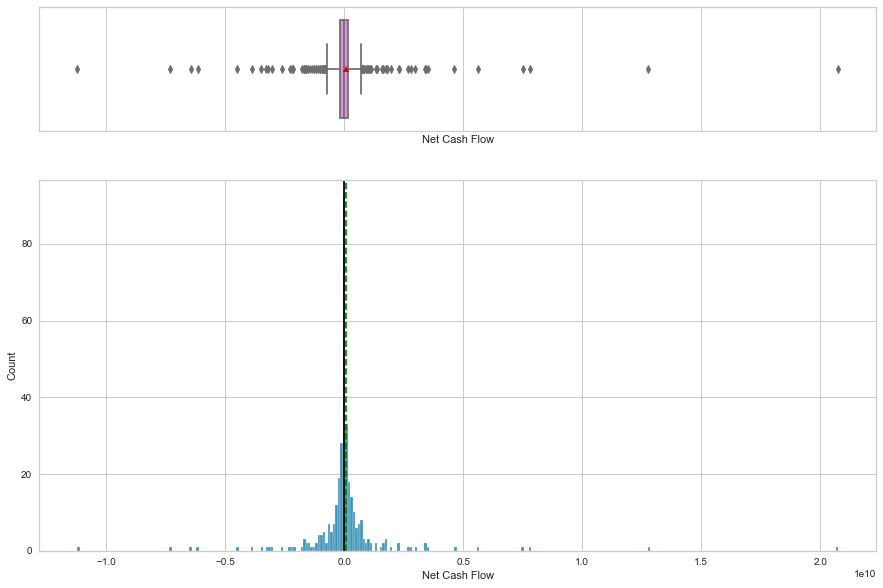

<IPython.core.display.Javascript object>

In [14]:
histogram_boxplot(data, "Net Cash Flow")

- ``Net Cash Flow`` is normally distributed with several outliers on either side.

#### Net Income

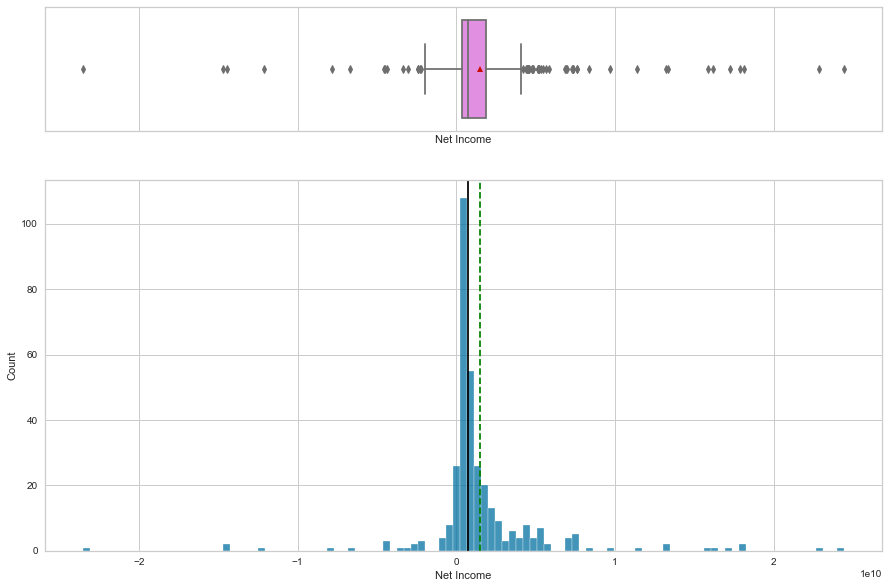

<IPython.core.display.Javascript object>

In [15]:
histogram_boxplot(data, "Net Income")

- ``Net Income`` is near normal with outliers on either side.

#### Earnings Per Share

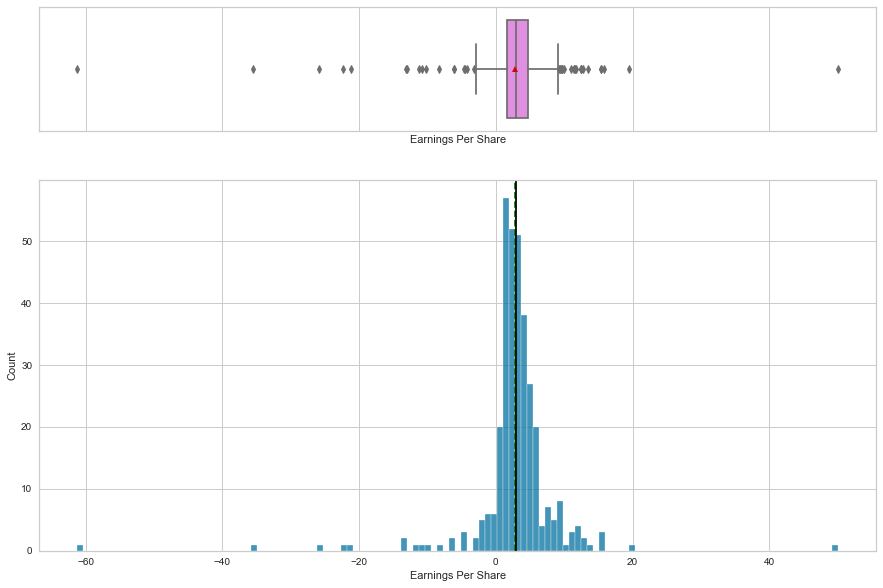

<IPython.core.display.Javascript object>

In [16]:
histogram_boxplot(data, "Earnings Per Share")

- This distribution is also near normal with outliers on either side.
- In many of these graphs, there appears to be a trend of a few extreme values falling far beyond the rest of the values. These could be companies that outperform (or underperform) the average company by a huge margin.

#### Estimated Shares Outstanding

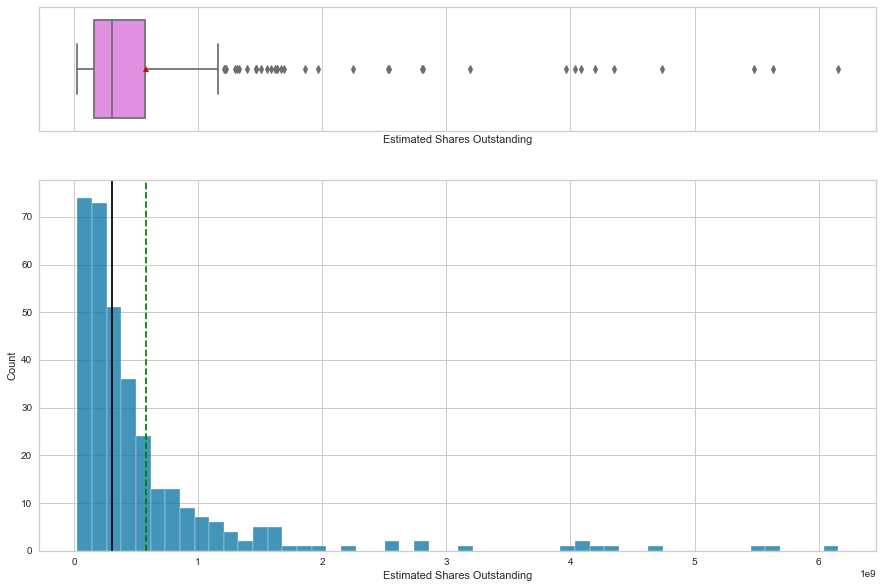

<IPython.core.display.Javascript object>

In [17]:
histogram_boxplot(data, "Estimated Shares Outstanding")

- Similar to ``Cash Ratio``, most ``Estimated Shares Outstanding`` values fall near zero on the x-axis. The value frequencies decrease as the number of shares increases.
- There are several outliers to the right on the boxplot whiskers.

#### P/E Ratio

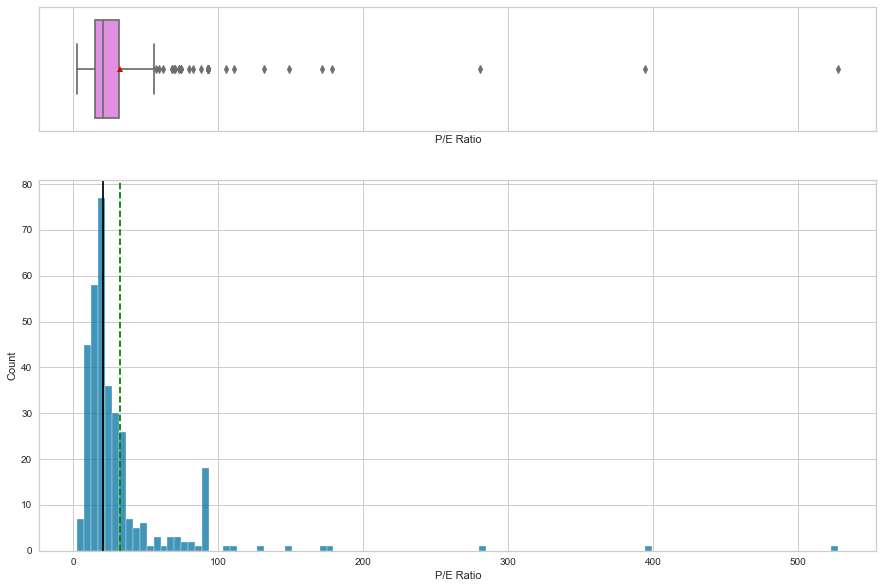

<IPython.core.display.Javascript object>

In [18]:
histogram_boxplot(data, "P/E Ratio")

- This distribution is roughly normal with several outliers to the right.
- There is an unexpected spike near 100.

#### P/B Ratio

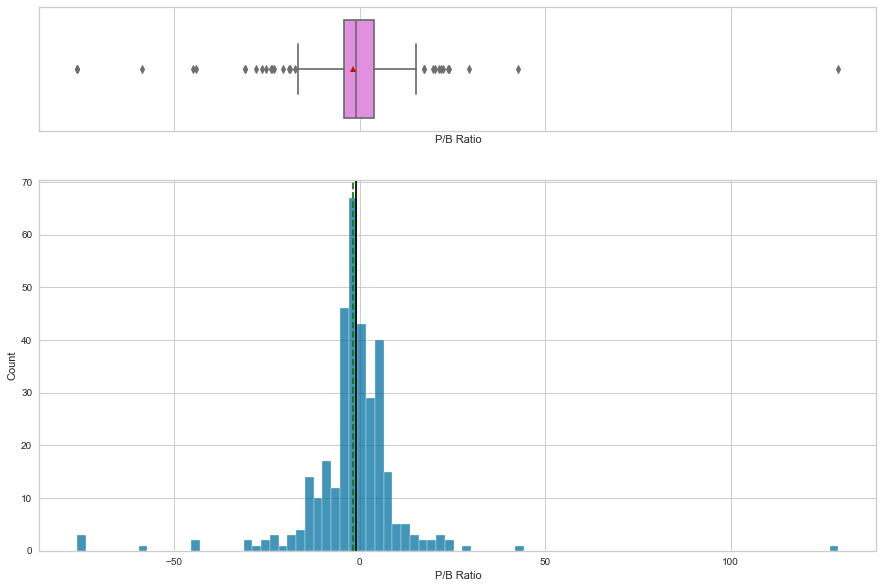

<IPython.core.display.Javascript object>

In [19]:
histogram_boxplot(data, "P/B Ratio")

- ``P/B Ratio`` is roughly normal with outliers on either side.

### Bivariate Analysis

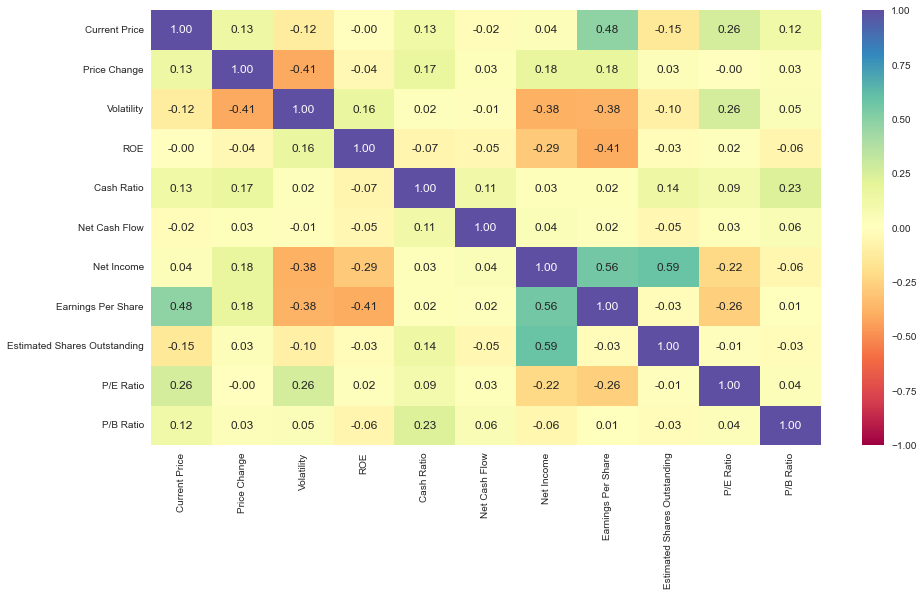

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- ``Volatility`` and ``Price Change`` have a slight negative correlation of -0.41.
- ``Net Income`` and ``Earnings Per Share`` have the same degree of negative correlation with Volatility, -0.38.
- ``ROE`` and ``Earnings Per Share`` are also slighly negatively correlated at -0.41.
- ``Earnings Per Share`` and ``Current Price`` are positively correlated at 0.48.
- ``Earnings Per Share`` and ``Net Income`` are postively correlated at 0.56.
- **``Net Income`` and ``Estimated Shares Outstanding`` have the highest degree of correlation** and are positively correlated at 0.59.

#### Net Income vs. Estimated Shares Outstanding

<AxesSubplot:xlabel='Net Income', ylabel='Estimated Shares Outstanding'>

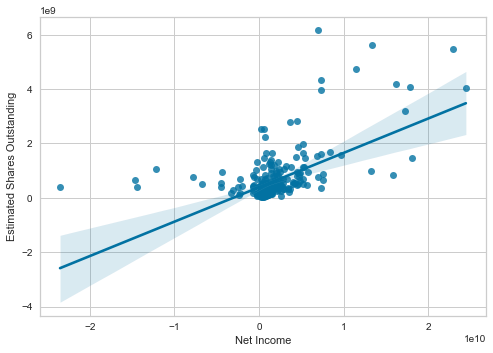

<IPython.core.display.Javascript object>

In [21]:
sns.regplot(data=data, x="Net Income", y="Estimated Shares Outstanding")

- As seen above, ``Net Income`` and ``Estimated Shares Outstanding`` are positively correlated.
- This means that companies with higher income tend to have a higher number of shares outstanding.

#### Price Change vs. Volatility

<AxesSubplot:xlabel='Price Change', ylabel='Volatility'>

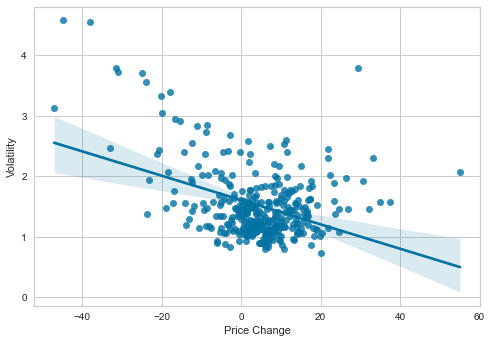

<IPython.core.display.Javascript object>

In [22]:
sns.regplot(data=data, x="Price Change", y="Volatility")

- As seen above, ``Volatility`` appears to have a slight negative correlation with ``Price Change``.
- This means that as the percentage price change increases, the volatility decreases.
    - This makes intuitive sense: a stock that is steadily going up over time is probably less volatile.

#### Earnings Per Share vs. Net Income

<AxesSubplot:xlabel='Earnings Per Share', ylabel='Net Income'>

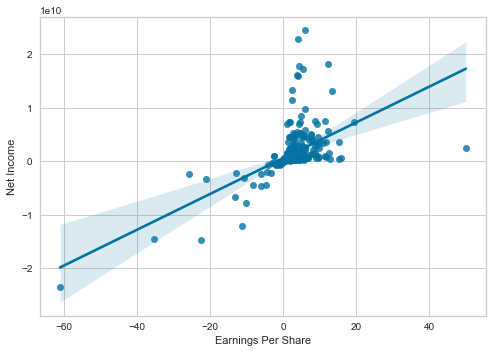

<IPython.core.display.Javascript object>

In [23]:
sns.regplot(data=data, x="Earnings Per Share", y="Net Income")

- ``Earnings Per Share`` and ``Net Income`` are positively correlated.
- As the ratio of earnings per share increases, net income also increases. This makes sense, because earnings and net income are similar measures.

#### GICS Sector vs. Current Price

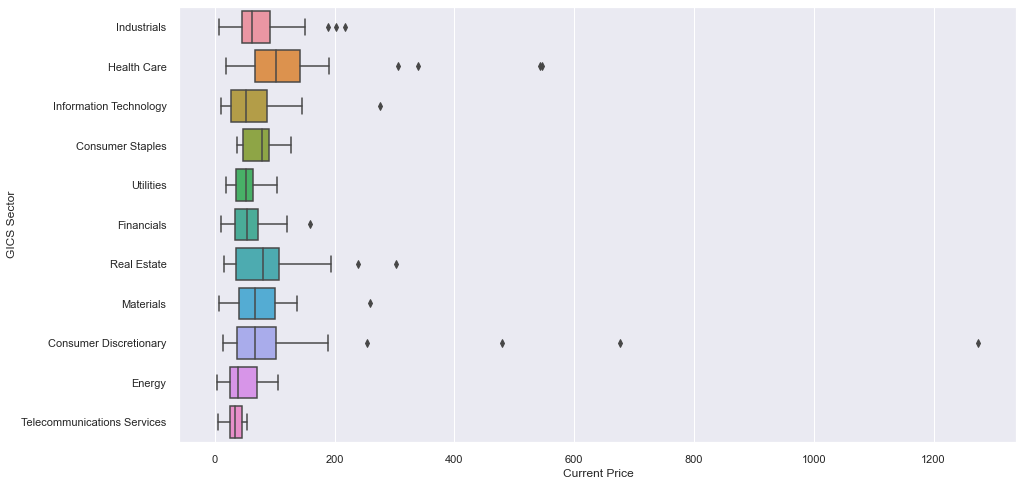

<IPython.core.display.Javascript object>

In [24]:
sns.set()
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, y="GICS Sector", x="Current Price")
plt.show()

- The Health Care sector has the highest median stock price.
- Real Estate has the second highest median stock price.
- The Consumer Discretionary sector is the only sector with outliers past \\$600.

#### GICS Sector vs. Net Income

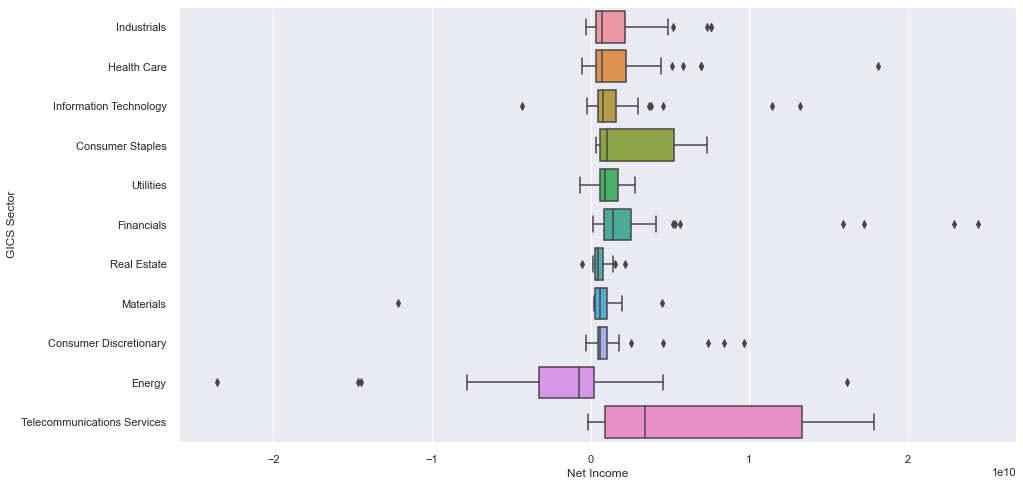

<IPython.core.display.Javascript object>

In [25]:
sns.set()
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, y="GICS Sector", x="Net Income")
plt.show()

- Telecommuncations Services stocks have the highest median Net Income.
- Stocks in the Energy sector have the lowest median Net Income.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
4. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

#### 1. What does the distribution of stock prices look like?

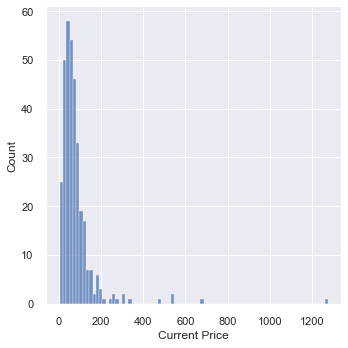

<IPython.core.display.Javascript object>

In [26]:
sns.displot(data=data, x="Current Price")

- The distribution of stock prices is near normal and heavily skewed to the right. 
- There are several outliers to the right.

#### 2. The stocks of which economic sector have seen the maximum price increase on average?

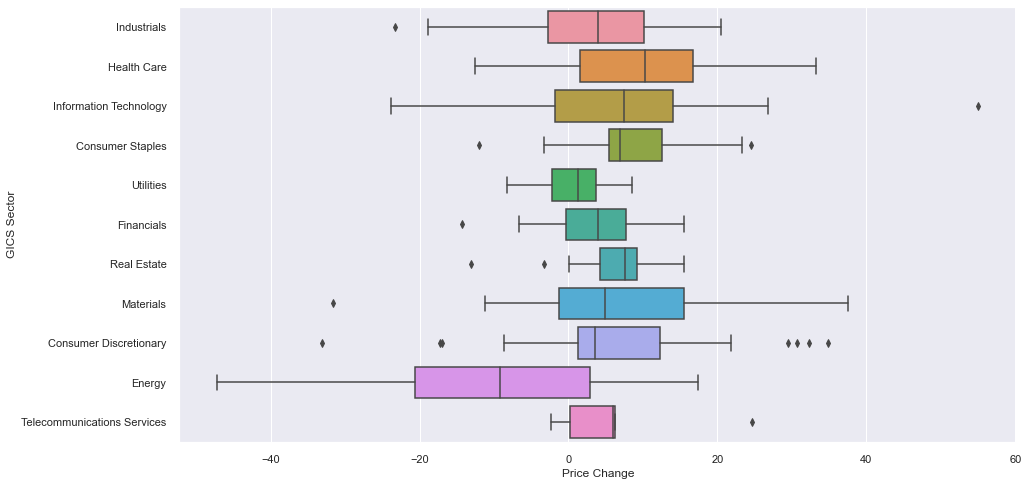

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x="Price Change", y="GICS Sector")
plt.show()

In [28]:
data["Price Change"].groupby(data["GICS Sector"]).median().sort_values(ascending=False)

GICS Sector
Health Care                    10.324402
Real Estate                     7.578608
Information Technology          7.496965
Consumer Staples                6.976738
Telecommunications Services     5.942118
Materials                       4.906245
Industrials                     3.952561
Financials                      3.910301
Consumer Discretionary          3.543658
Utilities                       1.281624
Energy                         -9.244788
Name: Price Change, dtype: float64

<IPython.core.display.Javascript object>

- The Health Care sector has the highest median ``Price Change``.
- IT and Real Estate have the next highest median price changes at approximately 7.5 and 7.58 respectively.

#### 3. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

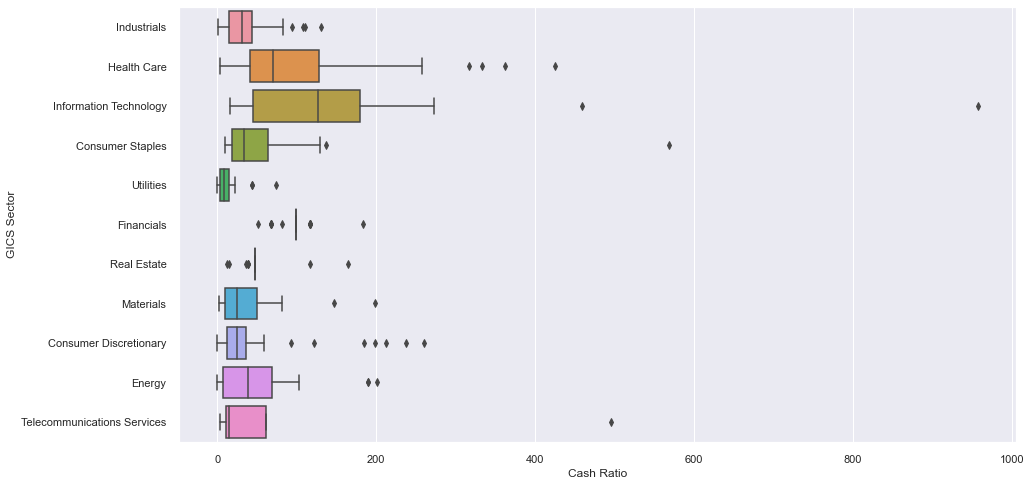

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x="Cash Ratio", y="GICS Sector")
plt.show()

In [30]:
data["Cash Ratio"].groupby(data["GICS Sector"]).median().sort_values(ascending=False)

GICS Sector
Information Technology         126.0
Financials                      99.0
Health Care                     70.0
Real Estate                     47.0
Energy                          38.5
Consumer Staples                33.0
Industrials                     31.0
Consumer Discretionary          25.0
Materials                       25.0
Telecommunications Services     14.0
Utilities                        8.5
Name: Cash Ratio, dtype: float64

<IPython.core.display.Javascript object>

- The IT sector has the highest median ``Cash Ratio`` at 126.
- The next highest is Financials, followed by Health Care.
- Utilities has the lowest median ``Cash Ratio`` at 8.5.

#### 4. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

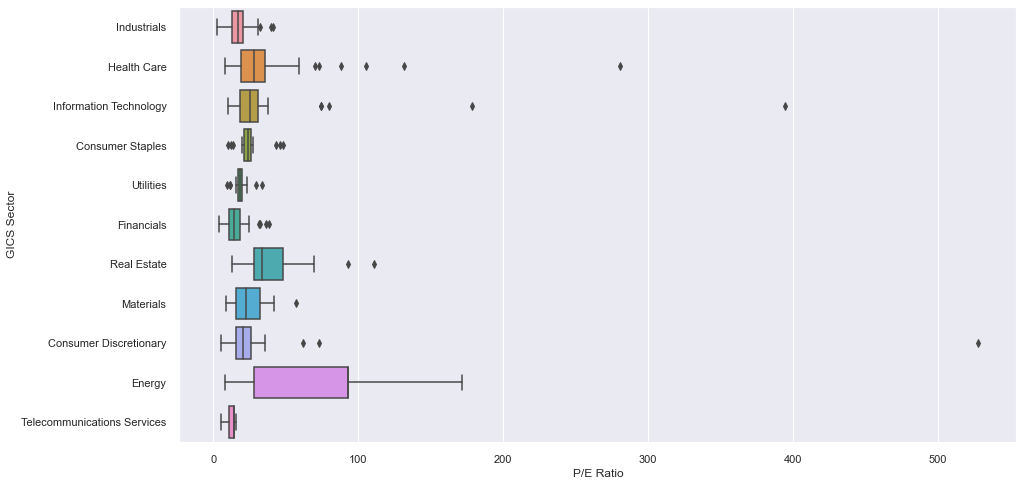

<IPython.core.display.Javascript object>

In [31]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x="P/E Ratio", y="GICS Sector")
plt.show()

In [32]:
data["P/E Ratio"].groupby(data["GICS Sector"]).median().sort_values(ascending=False)

GICS Sector
Energy                         93.089287
Real Estate                    33.685393
Health Care                    27.967442
Information Technology         25.309524
Consumer Staples               24.070121
Materials                      22.811951
Consumer Discretionary         20.819876
Utilities                      18.216489
Industrials                    17.334711
Telecommunications Services    14.518987
Financials                     14.276451
Name: P/E Ratio, dtype: float64

<IPython.core.display.Javascript object>

- The Energy sector has by far the highest median ``P/E Ratio`` at 93.09.
- Real Estate is second at 33.69, followed by Health Care at 27.97.
- This is interesting, because IT was among the highest sectors when measuring ``Price Change`` and ``Cash Ratio``, but it is lower when measuring ``P/E Ratio``.
- This suggests that investor outlook on Energy stocks is relatively high compared to their earnings.

## Data Preprocessing <a id='data_preprocessing'></a>

#### Duplicate Value Check

In [33]:
print(f"There are", data.duplicated().sum(), "duplicate values.")

There are 0 duplicate values.


<IPython.core.display.Javascript object>

#### Missing Value Treatment

In [34]:
print(f"There are", data.isnull().sum().sum(), "missing values.")

There are 0 missing values.


<IPython.core.display.Javascript object>

#### Outlier Check

- Because this data is clean and reliable, I assume that the outlier values are legitimate. Consequently, I will not treat the outliers.

#### Scaling the Data

In [35]:
scaled_data = zscore(
    data.drop(["Ticker Symbol", "Security", "GICS Sector", "GICS Sub Industry"], axis=1)
)
scaled_data.head()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,-0.393341,0.493950,0.272749,0.989601,-0.210698,-0.339355,1.554415,1.309399,0.107863,-0.652487,-0.506653
1,-0.220837,0.355439,1.137045,0.937737,0.077269,-0.002335,0.927628,0.056755,1.250274,-0.311769,-0.504205
2,-0.367195,0.602479,-0.427007,-0.192905,-0.033488,0.454058,0.744371,0.024831,1.098021,-0.391502,0.094941
3,0.133567,0.825696,-0.284802,-0.317379,1.218059,-0.152497,-0.219816,-0.230563,-0.091622,0.947148,0.424333
4,-0.260874,-0.492636,0.296470,-0.265515,2.237018,0.133564,-0.202703,-0.374982,1.978399,3.293307,0.199196


<IPython.core.display.Javascript object>

- Our data is now scaled.

In [36]:
scaled_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.0,1.453086e-17,1.001474,-0.779918,-0.432101,-0.216088,0.122741,12.195670
Price Change,340.0,-1.502066e-17,1.001474,-4.271357,-0.418535,0.061834,0.551963,4.251806
Volatility,340.0,-6.587868e-17,1.001474,-1.341642,-0.661838,-0.237564,0.286960,5.168258
ROE,340.0,2.873518e-17,1.001474,-0.400362,-0.309599,-0.255142,-0.130667,9.101176
Cash Ratio,340.0,-8.196058e-17,1.001474,-0.775555,-0.576194,-0.255000,0.320933,9.834905
Net Cash Flow,340.0,-7.224613e-18,1.001474,-5.795489,-0.128348,-0.027497,0.058798,10.655237
Net Income,340.0,6.040919e-18,1.001474,-6.359977,-0.290285,-0.200045,0.102842,5.832629
Earnings Per Share,340.0,4.555180e-17,1.001474,-9.725729,-0.185337,0.017990,0.280224,7.192572
Estimated Shares Outstanding,340.0,-1.244511e-16,1.001474,-0.650430,-0.495119,-0.316542,-0.004630,6.609320
P/E Ratio,340.0,1.665335e-17,1.001474,-0.670162,-0.396715,-0.266300,-0.019145,11.187619


<IPython.core.display.Javascript object>

- The scaled values are on the same scale, negating the effect of unit differences and allowing for easier comparison.

## K-means Clustering <a id='k-means'></a>

#### Plotting the Elbow Curve

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2659355306126447
Number of Clusters: 4 	Average Distortion: 2.185094363336472
Number of Clusters: 5 	Average Distortion: 2.1346156219311174
Number of Clusters: 6 	Average Distortion: 2.081348627428232
Number of Clusters: 7 	Average Distortion: 2.042223756885333
Number of Clusters: 8 	Average Distortion: 1.9879011866407563


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

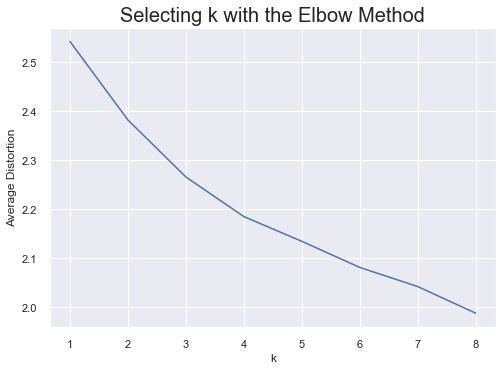

<IPython.core.display.Javascript object>

In [37]:
clusters = range(1, 9)  # setting a range for k
meanDistortions = []  # creating a list to store the mean distortions

for k in clusters:  # calculating the mean distortion for each k value
    model = KMeans(n_clusters=k)  # creating the model
    model.fit(scaled_data)  # fitting the data to the model
    prediction = model.predict(scaled_data)  # making predictions using the fitted model
    distortion = (
        sum(np.min(cdist(scaled_data, model.cluster_centers_, "euclidean"), axis=1))
        / scaled_data.shape[0]
    )

    meanDistortions.append(
        distortion
    )  # calculating and appending distortion to the list

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")  # plotting the k values vs. avg distortion
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

- There is a bend at 3 and again at 6. We will focus on these values for k. 

#### Checking the Silhouette Scores

For n_clusters = 2, silhouette score is 0.43969639509980457
For n_clusters = 3, silhouette score is 0.46288221478751007
For n_clusters = 4, silhouette score is 0.45483520750820555
For n_clusters = 5, silhouette score is 0.4262187611717761
For n_clusters = 6, silhouette score is 0.41439237473055257
For n_clusters = 7, silhouette score is 0.39899752915963094
For n_clusters = 8, silhouette score is 0.40193838741769927
For n_clusters = 9, silhouette score is 0.11317298632784413


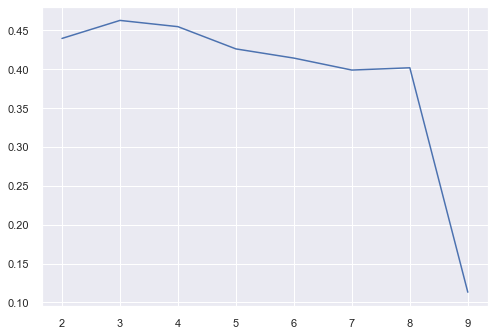

<IPython.core.display.Javascript object>

In [38]:
sil_score = []  # creating a list to store Silhouette Scores
cluster_list = list(range(2, 10))  # creating a range a values for k
for n_clusters in cluster_list:  # calculating Silhouette scores for each k value
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_data))
    score = silhouette_score(scaled_data, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)  # plotting the Silhoutte scores

- k = 3 has the highest Silhouette score. This is the value we will use.

#### Creating Cluster Profile

In [39]:
kmeans = KMeans(n_clusters=3, random_state=1)  # creating the model
kmeans.fit(scaled_data)  # fitting the model
df = data.copy()  # creating a copy of the dataframe
df["K_means_label"] = kmeans.labels_  # adding the cluster labels to dataframe

<IPython.core.display.Javascript object>

In [40]:
cluster_profile = df.groupby(
    "K_means_label"
).mean()  # grouping by cluster and calculating means
cluster_profile["# in cluster"] = (
    df.groupby("K_means_label")["Security"].count().values
)  # calculting the number of rows in each cluster
cluster_profile.style.highlight_max(
    color="lightgreen", axis=0
)  # highlighting max values

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,# in cluster
K_means_label,,,,,,,,,,,,
0,52.142857,6.779993,1.175153,26.142857,140.142857,760285714.285714,13368785714.285715,3.769286,3838879870.871428,20.654832,-3.529270,14
1,64.183438,-10.557046,2.797776,96.531250,70.718750,159171125.000000,-3250005968.750000,-7.886875,526459323.057500,111.333230,1.783445,32
2,84.045331,5.542488,1.404255,34.040816,66.608844,10698350.340136,1445333183.673469,3.890051,427206184.715408,24.613743,-2.013147,294


<IPython.core.display.Javascript object>

- There are 14 stocks in cluster 0, 32 in cluster 1, and 294 in cluster 2.
- **Cluster 2** has the highest average stock price and ``Earnings Per Share``.
- **Cluster 0** has the highest average ``Price Change``, ``Cash Ratio``, ``Net Cash Flow``, ``Net Income``, and ``Estimated Shares Outstanding``.
    - These are likely value stocks - companies with large amounts of cash and assets.
- **Cluster 1** has the highest ``Volatility``, ``ROE``, ``P/E Ratio``, and ``P/B Ratio``.
    - These seem to be stocks that are volatile and over-valued. 

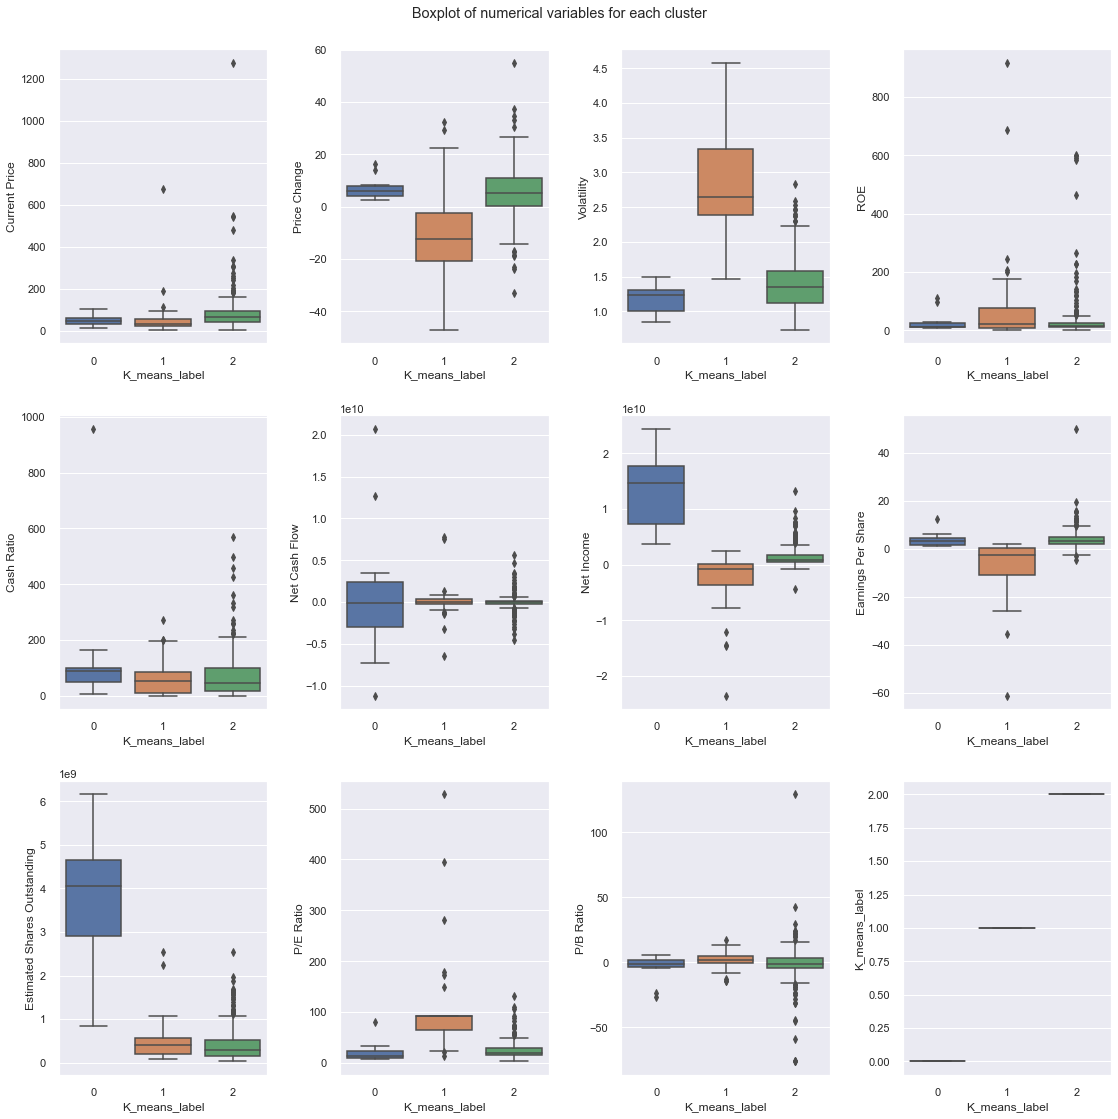

<IPython.core.display.Javascript object>

In [41]:
# creating boxplots of variables for each cluster
num_col = df.select_dtypes(
    include=np.number
).columns.tolist()  # isolating numeric columns
fig, axes = plt.subplots(
    3, 4, figsize=(16, 16)
)  # creating boxplots for each variable and cluster
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(3):
    sns.boxplot(ax=axes[ii, 0], y=df[num_col[counter]], x=df["K_means_label"])
    counter = counter + 1
    sns.boxplot(ax=axes[ii, 1], y=df[num_col[counter]], x=df["K_means_label"])
    counter = counter + 1
    sns.boxplot(ax=axes[ii, 2], y=df[num_col[counter]], x=df["K_means_label"])
    counter = counter + 1
    sns.boxplot(ax=axes[ii, 3], y=df[num_col[counter]], x=df["K_means_label"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

- These graphs underscore our previous observations.
- **Cluster 0**
    - Cluster 0 has the lowest ``Volatility`` and ``P/E Ratio``.
        - A low ``P/E Ratio`` indicates the stock may be undervalued.
    - Cluster 0 stocks have the highest ``Net Cash Flow``, ``Net Income``, and ``Estimated Shares Outstanding``.
        - Recall from our EDA that net income and estimated shares outstanding are positively correlated.
    - Cluster 0 stocks are undervalued and flush with cash. These stocks are potentially good investments.
- **Cluster 1**
    - In the 3rd graph, we see how high the ``Volatility`` of Cluster 1 stocks is compared to the other clusters. 
    - ``P/E Ratio`` is also highest for Cluster 1.
    - Cluster 1 has the lowest ``Net Income``, ``Earnings Per Share``, and ``Price Change``.
    - These are all indicators that Cluster 1 stocks are indeed over-valued and, as a corollary, bad investments.
- **Cluster 2**
    - Cluster 2 had the highest number of stocks. These are likely average in performance.
    - Cluster 2 plots have the highest variability and quantity of outliers.
    - Because of this, it is difficult to glean specific and useful information.
- Preliminary Conclusions:
    - It would be wise to further investigate Cluster 0 stocks for investment purposes. Cluster 1 stocks should be avoided.

In [42]:
print(
    f"Cluster 0 stocks include:\n", df[df["K_means_label"] == 0]["Security"].unique()
)  # listing the Cluster 0 stocks

Cluster 0 stocks include:
 ['Bank of America Corp' 'Citigroup Inc.' 'Ford Motor' 'Facebook'
 'Gilead Sciences' 'Intel Corp.' 'JPMorgan Chase & Co.'
 'Coca Cola Company' 'Merck & Co.' 'Pfizer Inc.' 'AT&T Inc'
 'Verizon Communications' 'Wells Fargo' 'Exxon Mobil Corp.']


<IPython.core.display.Javascript object>

## Hierarchical Clustering <a id='hierarchical'></a>

#### Calculating Cophenetic Correlations for Different Linkage Methods

In [43]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for (
    dm
) in distance_metrics:  # calculating correlations for each distance and linkage method
    for lm in linkage_methods:
        Z = linkage(scaled_data, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaled_data))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524591.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925307202850002.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159736.
Cophenetic correl

<IPython.core.display.Javascript object>

In [44]:
# isolating the distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {} with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814 with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

#### Testing Different Linkage Methods with Euclidean Distance

In [45]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:  # calculating correlations for all the linkage methods
    Z = linkage(scaled_data, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaled_data))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.


<IPython.core.display.Javascript object>

In [46]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {} with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814 with average linkage.


<IPython.core.display.Javascript object>

#### Plotting the Dendograms

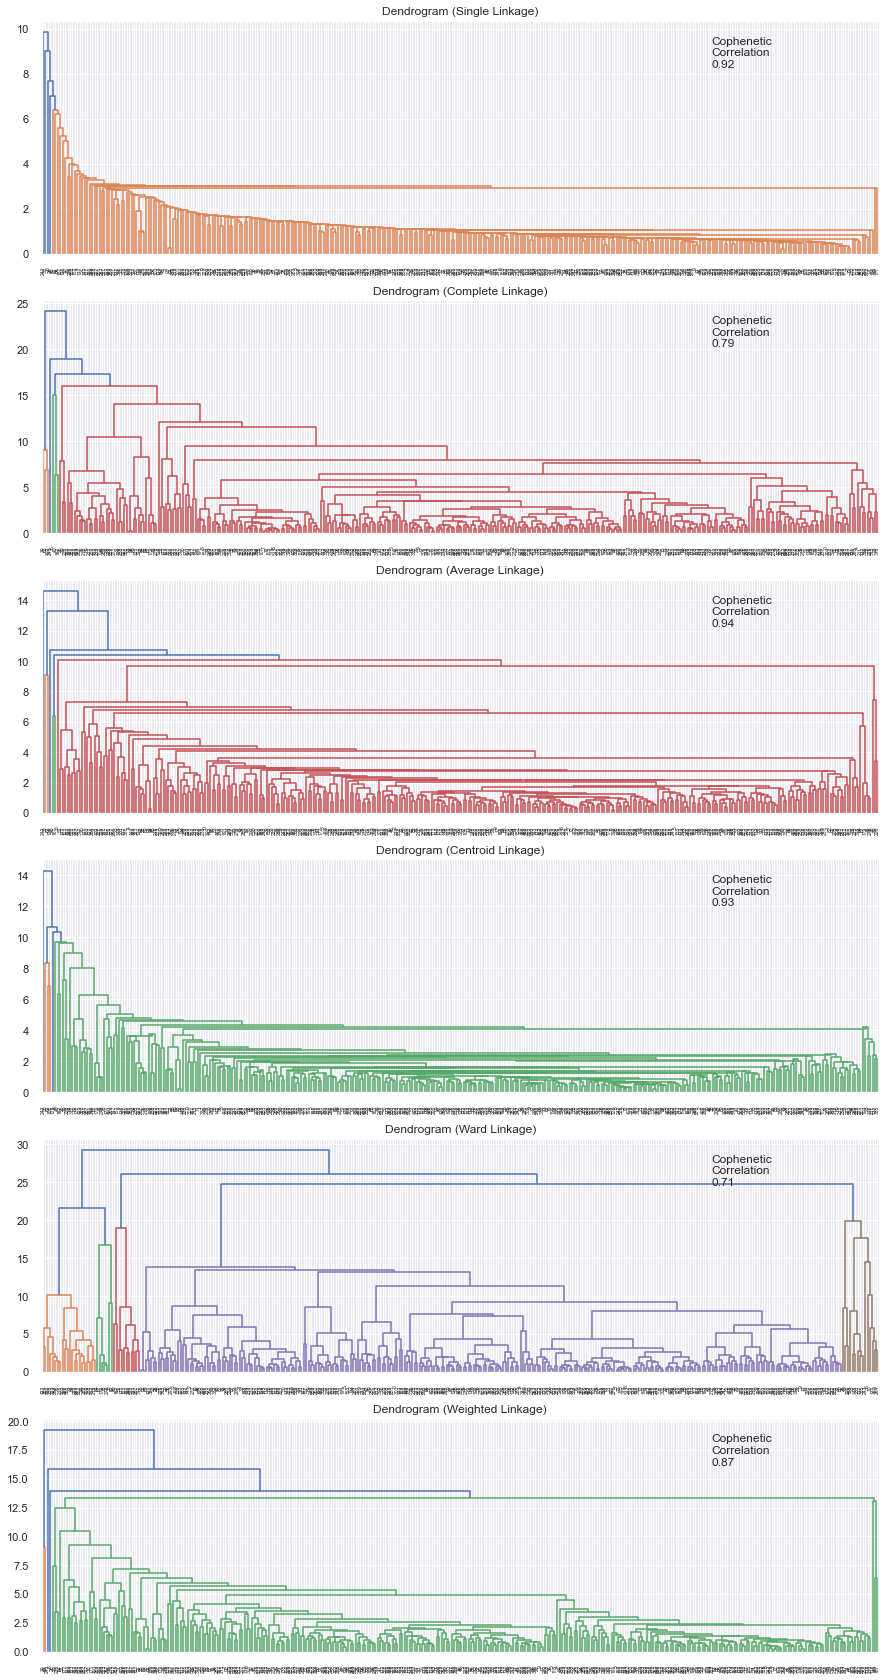

<IPython.core.display.Javascript object>

In [47]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# plotting the dendrogram and cophenetic correlation for each linkage method
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_data, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_data))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

- As we saw earlier, cophenetic correlation is highest for average linkage.
- 5 looks to be a good choice for number of clusters.

#### Clustering with Euclidean Distance and Average Linkage

In [48]:
HCmodel = AgglomerativeClustering(
    n_clusters=5, affinity="euclidean", linkage="average"
)  # trying 5 clusters with euclidean distance and average linkage
HCmodel.fit(scaled_data)  # fitting the model
df["HC_labels"] = HCmodel.labels_  # adding HC labels to original dataframe

<IPython.core.display.Javascript object>

#### Creating Cluster Profile

In [49]:
cluster_profile_hc = df.groupby("HC_labels").mean()  # creating cluster profile
cluster_profile_hc["# in HC cluster"] = df.groupby("HC_labels")["ROE"].count().values
cluster_profile_hc.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_label,# in HC cluster
HC_labels,,,,,,,,,,,,,
0,77.884243,4.105986,1.516865,35.320359,66.775449,-32825817.365269,1535255703.592814,2.903308,559027333.145509,32.437511,-1.781988,1.844311,334
1,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,0.000000,2
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,1.000000,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,0.000000,1
4,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,2.000000,1


<IPython.core.display.Javascript object>

- There are 334 stocks in Cluster 0 and 1-2 in each remaining cluster. This extremely inbalanced and will not give us any useful information. Let's try another linkage method.
- The dendrogram for Ward linkage appears to have the most distinct and balanced clusters. We will try this linkage method instead.

#### Clustering with Euclidean Distance and Ward Linkage

In [50]:
HCmodel = AgglomerativeClustering(
    n_clusters=5, affinity="euclidean", linkage="ward"
)  # creating model with euclidean distance and ward linkage
HCmodel.fit(scaled_data)  # fitting the model
df["HC_labels"] = HCmodel.labels_  # adding cluster labels

<IPython.core.display.Javascript object>

#### Creating Cluster Profile

In [51]:
cluster_profile_hc2 = df.groupby("HC_labels").mean()
cluster_profile_hc2["# in HC cluster"] = df.groupby("HC_labels")["ROE"].count().values
cluster_profile_hc2.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_label,# in HC cluster
HC_labels,,,,,,,,,,,,,
0,326.198218,10.563242,1.642560,14.400000,309.466667,288850666.666667,864498533.333333,7.785333,544900261.301333,113.095334,19.142151,1.666667,15
1,84.355716,3.854981,1.827670,633.571429,33.571429,-568400000.000000,-4968157142.857142,-10.841429,398169036.442857,42.284541,-11.589502,1.714286,7
2,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,0.000000,11
3,72.760400,5.213307,1.427078,25.603509,60.392982,79951512.280702,1538594322.807018,3.655351,446472132.228456,24.722670,-2.647194,1.964912,285
4,36.440455,-16.073408,2.832884,57.500000,42.409091,-472834090.909091,-3161045227.272727,-8.005000,514367806.201818,85.555682,0.836839,1.045455,22


<IPython.core.display.Javascript object>

- These clusters are more balanced.
- **Cluster 0** has the highest ``Current Price``, ``Price Change``, ``Cash Ratio``, ``Earnings Per Share``, ``P/E Ratio``, and ``P/B Ratio``.
- **Cluster 1** has the highest ``ROE`` by far.
- **Cluster 2** has the highest ``Net Cash Flow``, ``Net Income``, and ``Estimated Shares Outstanding``.
- **Cluster 3** does not have any maximum values. These are average or underperforming stocks.
- **Cluster 4** has the highest ``Volatility``.

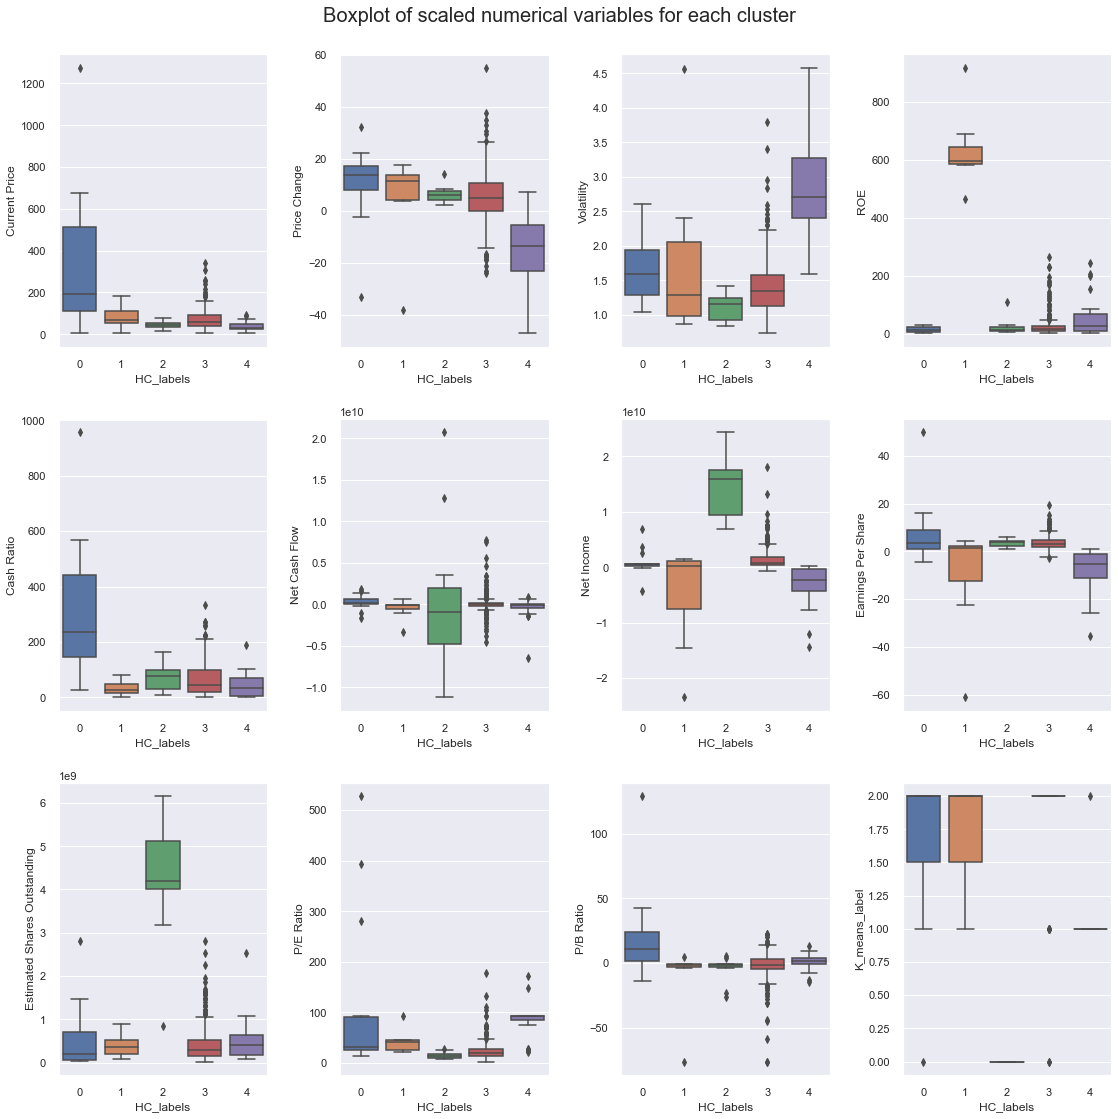

<IPython.core.display.Javascript object>

In [52]:
# creating boxplots of each variable by cluster
num_col2 = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(3, 4, figsize=(16, 16))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(3):
    sns.boxplot(
        ax=axes[ii][0], y=df[num_col2[counter]], x=df["HC_labels"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1], y=df[num_col2[counter]], x=df["HC_labels"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2], y=df[num_col2[counter]], x=df["HC_labels"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][3], y=df[num_col2[counter]], x=df["HC_labels"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

- **Cluster 0**
    - These stocks have the highest ``Current Price``, ``Price Change``, ``Cash Ratio``, ``Earnings Per Share``, ``P/E Ratio``, and ``P/B Ratio``.
    - They also have the lowest ``ROE``.
    - These are expensive stocks that have recently gone up in price.
    - As a result, it is probably too late to reap any significant benefit from investing in these stocks.
- **Cluster 1**
    - The stocks have by far the highest ``ROE``.
    - In other words, these companies are efficient at generating income and growth from equity financing.
    - These stocks could be profitable investments.
- **Cluster 2**
    - These stocks have the highest ``Net Income`` and ``Estimated Shares Outstanding``.
    - As we saw in the EDA, these two metrics are highly correlated.
    - These are revenue-generating companies and possibly good long term investments.
- **Cluster 3**
    - This cluster has the highest number of stocks and thus exhibits the most variability.
    - This cluster does not have any maximum values in the cluster profile.
    - These are likely average middle-of-the-pack stocks. Their value is likely priced in and there may be no significant financial benefit to investing in them.
- **Cluster 4**
    - Cluster 4 stocks are the most volatile. 
    - ``Volatility`` can be profitable for the discerning high risk investor.
    - These stocks can be looked at as high risk high reward.

In [53]:
# listing stocks in each cluster
print(
    f"Cluster 1 stocks include:\n", df[df["HC_labels"] == 1]["Security"].unique()
)  # listing the Cluster 1 stocks
print(
    f"Cluster 2 stocks include:\n", df[df["HC_labels"] == 2]["Security"].unique()
)  # listing the Cluster 2 stocks
print(
    f"Cluster 4 stocks include:\n", df[df["HC_labels"] == 4]["Security"].unique()
)  # listing the Cluster 4 stocks

Cluster 1 stocks include:
 ['Allegion' 'Apache Corporation' 'Chesapeake Energy'
 'Charter Communications' 'Colgate-Palmolive' 'Kimberly-Clark'
 'S&P Global, Inc.']
Cluster 2 stocks include:
 ['Bank of America Corp' 'Citigroup Inc.' 'Ford Motor' 'Intel Corp.'
 'JPMorgan Chase & Co.' 'Coca Cola Company' 'Pfizer Inc.' 'AT&T Inc'
 'Verizon Communications' 'Wells Fargo' 'Exxon Mobil Corp.']
Cluster 4 stocks include:
 ['Anadarko Petroleum Corp' 'Baker Hughes Inc' 'Cabot Oil & Gas'
 'Concho Resources' 'Devon Energy Corp.' 'EOG Resources'
 'Freeport-McMoran Cp & Gld' 'Hess Corporation' 'Kinder Morgan'
 'Marathon Oil Corp.' 'Murphy Oil' 'Noble Energy Inc'
 'Newfield Exploration Co' 'National Oilwell Varco Inc.' 'ONEOK'
 'Occidental Petroleum' 'Range Resources Corp.' 'Spectra Energy Corp.'
 'Southwestern Energy' 'Teradata Corp.' 'Williams Cos.' 'Cimarex Energy']


<IPython.core.display.Javascript object>

#### Cross Referencing Profitable Stocks from Both Algorithms

In [54]:
# creating a list of favorable stocks from each algorithm and finding stocks that were 'hits' for both
K_means_profit = [
    "Bank of America Corp",
    "Citigroup Inc.",
    "Ford Motor",
    "Facebook",
    "Gilead Sciences",
    "Intel Corp.",
    "JPMorgan Chase & Co.",
    "Coca Cola Company",
    "Merck & Co.",
    "Pfizer Inc.",
    "AT&T Inc",
    "Verizon Communications",
    "Wells Fargo",
    "Exxon Mobil Corp.",
]
HC_profit = [
    "Allegion",
    "Apache Corporation",
    "Chesapeake Energy",
    "Charter Communications",
    "Colgate-Palmolive",
    "Kimberly-Clark",
    "S&P Global, Inc.",
    "Bank of America Corp",
    "Citigroup Inc.",
    "Ford Motor",
    "Intel Corp.",
    "JPMorgan Chase & Co.",
    "Coca Cola Company",
    "Pfizer Inc.",
    "AT&T Inc",
    "Verizon Communications",
    "Wells Fargo",
    "Exxon Mobil Corp.",
]
both_profit = []

for stock in HC_profit:
    if stock in K_means_profit:
        both_profit.append(stock)

print("The following stocks were deemed profitable by both algorithms:\n", both_profit)

The following stocks were deemed profitable by both algorithms:
 ['Bank of America Corp', 'Citigroup Inc.', 'Ford Motor', 'Intel Corp.', 'JPMorgan Chase & Co.', 'Coca Cola Company', 'Pfizer Inc.', 'AT&T Inc', 'Verizon Communications', 'Wells Fargo', 'Exxon Mobil Corp.']


<IPython.core.display.Javascript object>

## K-means vs Hierarchical Clustering <a id='vs'></a>

- The K-means method took much less time and provided comprehensible results. The hierarchical clustering method took a couple iterations to get a reasonable result and the findings were less straightforward. The dendrograms are also difficult to read.
- For K-means we got 3 clusters. For hierarchical clustering we got 5. The K-means clusters were more distinct and easier to draw inferences from.
- Both clustering techniques identified expensive stocks with high values for ``P/E Ratio``, ``P/B Ratio``.
- Both clustering techniques categorized these companies has having exceptional metrics:
    - Bank of America Corp 
    - Citigroup Inc. 
    - Ford Motor 
    - Intel Corp. 
    - JPMorgan Chase & Co. 
    - Coca Cola Company 
    - Pfizer Inc. 
    - AT&T Inc 
    - Verizon Communications 
    - Wells Fargo 
    - Exxon Mobil Corp.
- K-means essentially grouped stocks into 3 categories: good investments, bad investments, and mediocre investments. This was easy to understand.
- Hierarchical clustering gave us the distinction between stocks with high ``ROE``, stocks with high ``Net Income``, and highly volatile stocks, each of which could be appealing to different types of investors. 
- Both techniques resulted in large clusters of average stocks.

## Actionable Insights & Recommendations <a id='insights_and_recs'></a>

#### K-means Method
- The following stocks were categorized as favorable by the K-means algorithm:
    - Bank of America Corp 
    - Citigroup Inc. 
    - Ford Motor 
    - Facebook 
    - Gilead Sciences 
    - Intel Corp. 
    - JPMorgan Chase & Co. 
    - Coca Cola Company 
    - Merck & Co. 
    - Pfizer Inc. 
    - AT&T Inc 
    - Verizon Communications 
    - Wells Fargo 
    - Exxon Mobil Corp.
- These are stocks with low ``Volatility`` and ``P/E Ratio`` (good), and high ``Net Cash Flow``, ``Net Income``, and ``Estimated Shares Outstanding`` (also good).
    - Low ``Volatility`` means the stock does not have significant price fluctuations, and a low ``P/E Ratio`` implies the stock price is low relative to the company's earnings.
    - High ``Net Cash Flow`` and ``Net Income`` are good for obvious reasons.
<br>
<br>

#### K-means and Hierarchical Combined 
- Out of the above stocks, the following were **also** identified favorably by hierarchical clustering:
    - Bank of America Corp 
    - Citigroup Inc. 
    - Ford Motor 
    - Intel Corp. 
    - JPMorgan Chase & Co. 
    - Coca Cola Company 
    - Pfizer Inc. 
    - AT&T Inc 
    - Verizon Communications 
    - Wells Fargo 
    - Exxon Mobil Corp.
- Because both algorithms used different techniques but still tagged these companies has having outstanding metrics, **it is likely that these stocks could be profitable long term investments.** Safe investors would be wise to perform further analysis on these stocks before investing.
<br>
<br>

#### Hierarchical Method
- Hierachical clustering identified these **volatile** stocks:
    - Anadarko Petroleum Corp 
    - Baker Hughes Inc 
    - Cabot Oil & Gas
    - Concho Resources 
    - Devon Energy Corp. 
    - EOG Resources
    - Freeport-McMoran Cp & Gld 
    - Hess Corporation 
    - Kinder Morgan
    - Marathon Oil Corp. 
    - Murphy Oil 
    - Noble Energy Inc
    - Newfield Exploration Co 
    - National Oilwell Varco Inc. 
    - ONEOK
    - Occidental Petroleum 
    - Range Resources Corp. 
    - Spectra Energy Corp.
    - Southwestern Energy 
    - Teradata Corp. 
    - Williams Cos. 
    - Cimarex Energy
- While these stocks would not appeal to the conservative investor, ``Volatility`` can be profitable to the investor with high risk tolerance. Intrepid investors interested in the possibility of short-term profits from swing trading may look at these stocks.